In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import joblib
import os

# === Step 1: Load Data ===
train_data = pd.read_parquet("train_data.parquet")
test_data = pd.read_parquet("test_data.parquet")
df = pd.concat([train_data, test_data], ignore_index=True)

# === Step 2: Extract Time Features ===
def extract_time_features(df, timestamp_col='timestamp', market_open_time='09:15:00'):
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    df['second'] = df[timestamp_col].dt.second
    df['minute'] = df[timestamp_col].dt.minute
    df['hour'] = df[timestamp_col].dt.hour
    market_open = pd.to_datetime(df[timestamp_col].dt.date.astype(str) + f' {market_open_time}')
    df['seconds_since_open'] = (df[timestamp_col] - market_open).dt.total_seconds()
    df['seconds_in_day'] = df['hour'] * 3600 + df['minute'] * 60 + df['second']
    max_seconds = 23400  # 6.5 trading hours
    df['time_sin'] = np.sin(2 * np.pi * df['seconds_in_day'] / max_seconds)
    df['time_cos'] = np.cos(2 * np.pi * df['seconds_in_day'] / max_seconds)
    df.drop(columns=[timestamp_col], inplace=True)
    return df

df = extract_time_features(df)

# === Step 3: Add Expiry Features ===
if 'days_to_expiry' not in df.columns:
    df['days_to_expiry'] = 5  # default fallback
df['time_to_expiry'] = df['days_to_expiry'] / 365

# === Step 4: BSM Greeks ===
def compute_bsm_features(S, K, T, r, sigma):
    try:
        if sigma <= 0 or T <= 0:
            return np.nan, np.nan, np.nan
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        delta = norm.cdf(d1)
        vega = S * norm.pdf(d1) * np.sqrt(T)
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        return delta, vega, gamma
    except:
        return np.nan, np.nan, np.nan

# === Step 5: Setup ===
base_feature_cols = [f'X{i}' for i in range(42)] + [
    'underlying', 'second', 'minute', 'hour',
    'seconds_since_open', 'time_sin', 'time_cos'
]
risk_free_rate = 0.06
iv_cols = [col for col in df.columns if col.startswith('call_iv_') or col.startswith('put_iv_')]
nearby_iv_cols = ['call_iv_24400', 'call_iv_24600']
rmses = []
trained_models = {}

# === Step 6: Data Cleaning ===
def clean_training_data(df, target_iv, feature_cols, max_iv=5.0):
    train_df = df[df[target_iv].notna()].copy()
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    train_df.dropna(subset=feature_cols + [target_iv], inplace=True)
    train_df = train_df[(train_df[target_iv] > 0) & (train_df[target_iv] < max_iv)]
    return train_df

# === Step 7: Train Models ===
os.makedirs("models", exist_ok=True)

for target_iv in iv_cols:
    strike = int(target_iv.split('_')[-1])

    # Compute Greeks using the target IV
    df[['bsm_delta', 'bsm_vega', 'bsm_gamma']] = df.apply(
        lambda row: compute_bsm_features(
            S=row['underlying'],
            K=strike,
            T=row['time_to_expiry'],
            r=risk_free_rate,
            sigma=row[target_iv] if pd.notna(row[target_iv]) else 0.2
        ),
        axis=1, result_type='expand'
    )

    feature_cols = base_feature_cols + ['bsm_delta', 'bsm_vega', 'bsm_gamma']
    for col in nearby_iv_cols:
        if col != target_iv and col in df.columns:
            feature_cols.append(col)

    train_df = clean_training_data(df, target_iv, feature_cols)
    if train_df.empty:
        print(f" Skipping {target_iv}: No valid training data.")
        continue

    X = train_df[feature_cols]
    y = train_df[target_iv]
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        tree_method='hist',
        n_jobs=-1,
        random_state=42
    )
    model.fit(X_tr, y_tr)
    joblib.dump(model, f"models/{target_iv}_model.pkl")
    trained_models[target_iv] = model

    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred)
    rmses.append(rmse)
    print(f" RMSE for {target_iv}: {rmse:.6f}")

# === Step 8: Print Average RMSE ===
if rmses:
    print(f"\n Average Validation RMSE: {np.mean(rmses):.8f}")
else:
    print(" No models trained.")



 RMSE for call_iv_23500: 0.000009
 RMSE for call_iv_23600: 0.000010
 RMSE for call_iv_23700: 0.000006
 RMSE for call_iv_23800: 0.000005
 RMSE for call_iv_23900: 0.000002
 RMSE for call_iv_24000: 0.000001
 RMSE for call_iv_24100: 0.000001
 RMSE for call_iv_24200: 0.000000
 RMSE for call_iv_24300: 0.000000
 RMSE for call_iv_24400: 0.000000
 RMSE for call_iv_24500: 0.000000
 RMSE for call_iv_24600: 0.000000
 RMSE for call_iv_24700: 0.000001
 RMSE for call_iv_24800: 0.000001
 RMSE for call_iv_24900: 0.000002
 RMSE for call_iv_25000: 0.000001
 RMSE for call_iv_25100: 0.000002
 RMSE for call_iv_25200: 0.000003
 RMSE for call_iv_25300: 0.000006
 RMSE for call_iv_25400: 0.000003
 RMSE for call_iv_25500: 0.000004
 RMSE for call_iv_25600: 0.000004
 RMSE for call_iv_25700: 0.000004
 RMSE for call_iv_25800: 0.000004
 RMSE for call_iv_25900: 0.000007
 RMSE for call_iv_26000: 0.000004
 RMSE for put_iv_22500: 0.000005
 RMSE for put_iv_22600: 0.000004
 RMSE for put_iv_22700: 0.000004
 RMSE for put_iv_

/tmp/ipython-input-451387676.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.replace([np.inf, -np.inf], np.nan, inplace=True)


 RMSE for call_iv_26100: 0.000002


/tmp/ipython-input-451387676.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.replace([np.inf, -np.inf], np.nan, inplace=True)


 RMSE for call_iv_26200: 0.000013


/tmp/ipython-input-451387676.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.replace([np.inf, -np.inf], np.nan, inplace=True)


 RMSE for call_iv_26300: 0.000009


/tmp/ipython-input-451387676.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.replace([np.inf, -np.inf], np.nan, inplace=True)


 RMSE for call_iv_26400: 0.000004


/tmp/ipython-input-451387676.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.replace([np.inf, -np.inf], np.nan, inplace=True)


 RMSE for call_iv_26500: 0.000018


/tmp/ipython-input-451387676.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.replace([np.inf, -np.inf], np.nan, inplace=True)


 RMSE for put_iv_25100: 0.000002


/tmp/ipython-input-451387676.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.replace([np.inf, -np.inf], np.nan, inplace=True)


 RMSE for put_iv_25200: 0.000003


/tmp/ipython-input-451387676.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.replace([np.inf, -np.inf], np.nan, inplace=True)


 RMSE for put_iv_25300: 0.000010


/tmp/ipython-input-451387676.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.replace([np.inf, -np.inf], np.nan, inplace=True)


 RMSE for put_iv_25400: 0.000013


/tmp/ipython-input-451387676.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.replace([np.inf, -np.inf], np.nan, inplace=True)


 RMSE for put_iv_25500: 0.000009

 Average Validation RMSE: 0.00000378


In [ ]:
# === Step 9: Generate Submission with All Calls and Puts ===
print("\n Generating final submission...")

submission_preds = {}

for target_iv, model in trained_models.items():
    strike = int(target_iv.split('_')[-1])
    prefix = 'call' if 'call' in target_iv else 'put'
    colname = f"{prefix}_{strike}"

    df[['bsm_delta', 'bsm_vega', 'bsm_gamma']] = df.apply(
        lambda row: compute_bsm_features(
            S=row['underlying'],
            K=strike,
            T=row['time_to_expiry'],
            r=risk_free_rate,
            sigma=row[target_iv] if pd.notna(row[target_iv]) else 0.2
        ),
        axis=1, result_type='expand'
    )

    feature_cols = base_feature_cols + ['bsm_delta', 'bsm_vega', 'bsm_gamma']
    for extra_col in nearby_iv_cols:
        if extra_col != target_iv and extra_col in df.columns:
            feature_cols.append(extra_col)

    X_pred = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    preds = model.predict(X_pred)
    submission_preds[colname] = preds[:12065]

# === Step 10: Format and Save ===
submission_df = pd.DataFrame(submission_preds).iloc[:12065].copy()
submission_df.index = np.arange(12065)

call_cols = sorted([col for col in submission_df.columns if col.startswith("call_")])
put_cols = sorted([col for col in submission_df.columns if col.startswith("put_")])
submission_df = submission_df[call_cols + put_cols]

submission_df.to_csv("final_submission_all_calls_puts.csv", index=False)
print(f" Saved submission as final_submission_all_calls_puts.csv with shape {submission_df.shape}")



 Generating final submission...


KeyboardInterrupt: 

In [ ]:
import shutil

shutil.move("final_submission_all_calls_puts.csv", "/content/final_submission_all_calls_puts.csv")  # if using Google Colab

from google.colab import files
files.download("final_submission_all_calls_puts.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_csv('sample_submission.csv')
df.shape

(12065, 53)

In [ ]:
df.head()

NameError: name 'df' is not defined

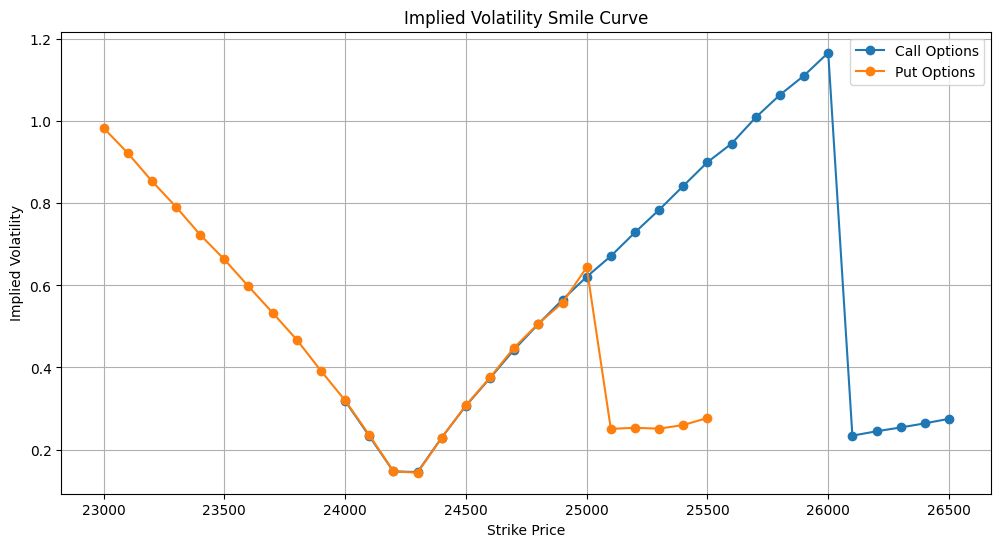

In [ ]:
import matplotlib.pyplot as plt

# Load the submission file
submission_df = pd.read_csv("Final NK - Sheet1 (1).csv")

# Extract call and put IV columns
call_cols = sorted([col for col in submission_df.columns if col.startswith("call_")])
put_cols = sorted([col for col in submission_df.columns if col.startswith("put_")])

# Extract strikes
call_strikes = [int(col.split('_')[-1]) for col in call_cols]
put_strikes = [int(col.split('_')[-1]) for col in put_cols]

# Calculate average IV for each strike across all rows
avg_call_iv = submission_df[call_cols].mean()
avg_put_iv = submission_df[put_cols].mean()

# Sort strikes and corresponding average IVs
call_strikes, avg_call_iv = zip(*sorted(zip(call_strikes, avg_call_iv)))
put_strikes, avg_put_iv = zip(*sorted(zip(put_strikes, avg_put_iv)))

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(call_strikes, avg_call_iv, marker='o', linestyle='-', label='Call Options')
plt.plot(put_strikes, avg_put_iv, marker='o', linestyle='-', label='Put Options')

plt.title('Implied Volatility Smile Curve')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.legend()
plt.show()